In [312]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [313]:
import sys

sys.path.append("../")

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from typing import List
from scipy.spatial import KDTree
from IPython.display import display
from matplotlib import pyplot as plt

from src.config import TRACKING_PATH, RAW_GAZE_FRAME_WIDTH, RAW_GAZE_FRAME_HEIGHT, IMAGE_WIDTH, IMAGE_HEIGHT, SETS_PATH
from src.utils.gaze_data import get_gaze_data
from src.utils.file import get_files_recursive, get_sequence_id_from_file_path

N_NSEC_IN_SEC = 1e9
BOUNDING_BOX_MARGIN_PX = 10

## Get Fixation and Object Data

In [314]:
def get_fixation_data():
    """
    Get gaze data for experiment 1, set 0

    Returns:
        pd.DataFrame: Gaze data for videos
    """
    fixation_data = get_gaze_data(
        experiment_ids=[1],
        set_ids=[0],
        fixation=True,
    )
    fixation_data = fixation_data.drop(columns=["ExperimentId", "SessionId", "SetId", "ParticipantId", "X_sc", "Y_sc"])

    # Add Fixation Id
    fixation_data["FixationId"] = np.arange(len(fixation_data))

    fixation_data = fixation_data[[
        "SequenceId",
        "FixationId",
        "X_px",
        "Y_px",
        "StartTimestamp_ns",
        "EndTimestamp_ns",
        "Duration_ns",
        "TimeSinceStart_ns",
    ]]

    return fixation_data

fixation_data = get_fixation_data()
fixation_data

,SequenceId,FixationId,X_px,Y_px,StartTimestamp_ns,EndTimestamp_ns,Duration_ns,TimeSinceStart_ns
700,4,0,1567.1270,2849.3953,8492801526800000000,8492801526950000000,150000000,200000000
701,4,1,3471.4950,1682.1431,8492801527250000000,8492801527575000000,325000000,650000000
702,4,2,3317.9890,1793.1824,8492801527975000000,8492801528100000000,125000000,1375000000
703,4,3,2956.6367,2178.8462,8492801528300000000,8492801528525000000,225000000,1700000000
704,4,4,2923.9175,1900.6980,8492801528625000000,8492801528950000000,325000000,2025000000
...,...,...,...,...,...,...,...,...
283943,15,144609,3685.3867,943.7742,8496624306100000000,8496624306300000000,200000000,67350000000
283944,15,144610,4243.6300,1060.9862,8496624306900000000,8496624307025000000,125000000,68150000000
283945,15,144611,3479.2664,1677.1112,8496624307025000000,8496624307250000000,225000000,68275000000
283946,15,144612,3478.1667,1734.3223,8496624307250000000,8496624307375000000,125000000,68500000000


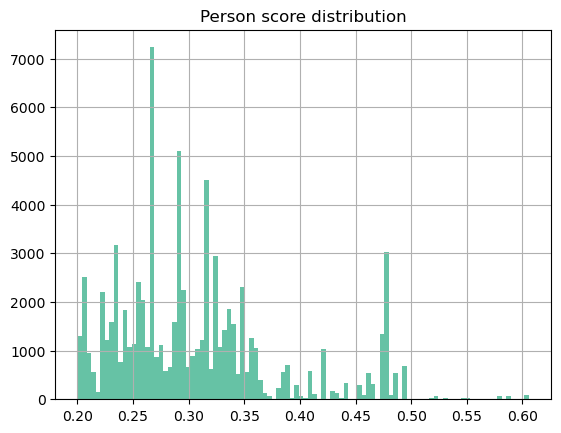

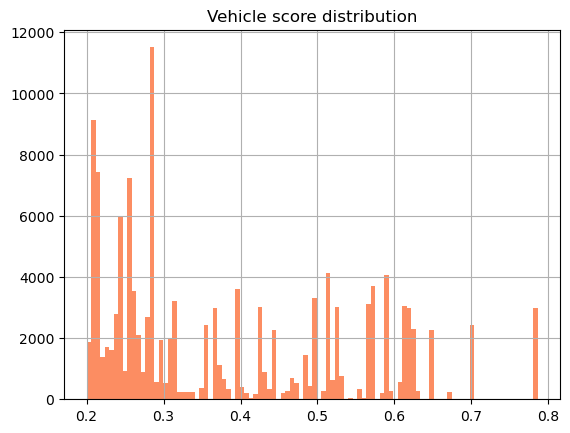

,SequenceId,InstanceId,FrameId,LabelStr,LabelClass,CenterX_px,CenterY_px,Width_px,Height_px,Area_px2,DistanceFromLast_px,AngleFromLast_deg,TimeSinceStart_ns,TimeSinceAppearance_ns,StartTime_ns,Lifetime_ns,MeanDistanceFromLast_px
0,1,0,0,car,vehicle,3345.136477,2487.543314,308.839597,249.576889,77079.225598,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+11,0.017606
1,1,0,1,car,vehicle,3345.117696,2487.538517,308.917038,249.654260,77122.454484,0.007446,-169.611142,4.000000e+07,4.000000e+07,0.000000e+00,1.200000e+11,0.017606
2,1,0,2,car,vehicle,3345.073560,2487.423183,309.079356,249.726095,77185.180648,0.036589,-118.061243,8.000000e+07,8.000000e+07,0.000000e+00,1.200000e+11,0.017606
3,1,0,3,car,vehicle,3345.036624,2487.328779,309.264240,249.861834,77273.330427,0.030099,-118.591914,1.200000e+08,1.200000e+08,0.000000e+00,1.200000e+11,0.017606
4,1,0,4,car,vehicle,3345.012834,2487.158721,309.500666,250.000967,77375.466035,0.048503,-101.027132,1.600000e+08,1.600000e+08,0.000000e+00,1.200000e+11,0.017606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149383,14,33,2994,car,vehicle,4151.424666,2726.713953,219.700568,312.799470,68722.221139,0.075582,154.966335,1.197600e+11,1.396000e+10,1.058000e+11,1.412000e+10,0.116697
149384,14,33,2995,car,vehicle,4151.332012,2726.709811,219.769547,312.907347,68767.505848,0.036151,-178.161746,1.198000e+11,1.400000e+10,1.058000e+11,1.412000e+10,0.116697
149385,14,33,2996,car,vehicle,4151.370513,2726.966206,219.597740,312.458228,68615.120807,0.073331,78.185025,1.198400e+11,1.404000e+10,1.058000e+11,1.412000e+10,0.116697
149386,14,33,2997,car,vehicle,4151.397433,2727.130378,219.424908,312.111878,68485.120162,0.047143,77.133263,1.198800e+11,1.408000e+10,1.058000e+11,1.412000e+10,0.116697


In [316]:
def get_object_data(
        person_score_threshold: float = 0.2,
        vehicle_score_threshold: float = 0.3,
        bounding_box_margin_px: int = BOUNDING_BOX_MARGIN_PX
):
    """
    Get tracking data for objects.

    Args:
        person_score_threshold (float): Minimum score for a person object to be considered
        vehicle_score_threshold (float): Minimum score for a vehicle object to be considered
        bounding_box_margin_px (int): Margin to add to bounding box

    Returns:
        pd.DataFrame: Tracking data for objects
    """
    # Concatenate all tracking data
    all_tracking_data = []
    file_paths = get_files_recursive(TRACKING_PATH, "scene*.csv")
    for file_path in file_paths:
        sequence_id = get_sequence_id_from_file_path(file_path)
        tracking_data = pd.read_csv(file_path)
        tracking_data["SequenceId"] = sequence_id
        all_tracking_data.append(tracking_data)

    all_tracking_data = pd.concat(all_tracking_data)

    # Merge vehicle classes
    all_tracking_data["LabelClass"] = all_tracking_data["LabelStr"].replace(
        {
            "truck": "vehicle",
            "bus": "vehicle",
            "car": "vehicle",
            "motorcycle": "vehicle",
            "bike": "vehicle",
        }
    )

    # Remove objects that are not people or vehicles
    all_tracking_data = all_tracking_data[~all_tracking_data["LabelClass"].str.contains("building")]

    # Plot score distributions before filtering
    colors = sns.color_palette("Set2", n_colors=2)
    all_tracking_data[all_tracking_data["LabelClass"] == "person"]["Score"].hist(bins=100, color=colors[0])
    plt.title("Person score distribution")
    plt.show()
    all_tracking_data[all_tracking_data["LabelClass"] == "vehicle"]["Score"].hist(bins=100, color=colors[1])
    plt.title("Vehicle score distribution")
    plt.show()

    # Filter out objects with low scores
    all_tracking_data = all_tracking_data[
        ((all_tracking_data["LabelClass"] == "person")
        & (all_tracking_data["Score"] > person_score_threshold))
        | ((all_tracking_data["LabelClass"] == "vehicle")
        & (all_tracking_data["Score"] > vehicle_score_threshold))
    ]

    # Get distance and angle from last frame
    all_tracking_data = all_tracking_data.sort_values(["SequenceId", "InstanceId", "FrameId"])
    all_tracking_data["CenterXDiff_px"] = all_tracking_data.groupby(["SequenceId", "InstanceId"])["CenterX_px"].diff()
    all_tracking_data["CenterYDiff_px"] = all_tracking_data.groupby(["SequenceId", "InstanceId"])["CenterY_px"].diff()
    all_tracking_data["DistanceFromLast_px"] = np.sqrt(all_tracking_data["CenterXDiff_px"]**2 + all_tracking_data["CenterYDiff_px"]**2)
    all_tracking_data["AngleFromLast_deg"] = np.arctan2(all_tracking_data["CenterYDiff_px"], all_tracking_data["CenterXDiff_px"]).apply(np.degrees)
    all_tracking_data = all_tracking_data.drop(columns=["CenterXDiff_px", "CenterYDiff_px"])

    # Transform pixel space to the same space as gaze data
    all_tracking_data["CenterX_px"] = all_tracking_data["CenterX_px"] / IMAGE_WIDTH * RAW_GAZE_FRAME_WIDTH
    all_tracking_data["CenterY_px"] = all_tracking_data["CenterY_px"] / IMAGE_HEIGHT * RAW_GAZE_FRAME_HEIGHT

    # Add bounding box margin and clip to image size
    all_tracking_data["BoundingBox_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: list(map(float, x.strip("[]").split())))
    all_tracking_data["BoundingBox_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: [x[0] - bounding_box_margin_px, x[1] - bounding_box_margin_px, x[2] + bounding_box_margin_px, x[3] + bounding_box_margin_px])
    all_tracking_data["BoundingBox_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: [max(0, x[0]), max(0, x[1]), min(IMAGE_WIDTH, x[2]), min(IMAGE_HEIGHT, x[3])])
    
    # Get width and height of bounding box, and transform to the same space as gaze data
    all_tracking_data["Width_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: x[2] - x[0])
    all_tracking_data["Height_px"] = all_tracking_data["BoundingBox_px"].apply(lambda x: x[3] - x[1])
    all_tracking_data["Width_px"] = all_tracking_data["Width_px"] / IMAGE_WIDTH * RAW_GAZE_FRAME_WIDTH
    all_tracking_data["Height_px"] = all_tracking_data["Height_px"] / IMAGE_HEIGHT * RAW_GAZE_FRAME_HEIGHT
    all_tracking_data["Area_px2"] = all_tracking_data["Width_px"] * all_tracking_data["Height_px"]


    # Get start time, lifetime and mean distance from last for each object
    other_data = all_tracking_data.groupby(["SequenceId", "InstanceId"]).agg(
        StartTime_ns=("TimeSinceStart_ns", "min"),
        Lifetime_ns=("TimeSinceStart_ns", lambda x: x.max() - x.min()),
        MeanDistanceFromLast_px=("DistanceFromLast_px", "mean")
    ).reset_index()
    all_tracking_data = all_tracking_data.merge(other_data, on=["SequenceId", "InstanceId"], how="left")

    # Get time since appearance
    all_tracking_data["TimeSinceAppearance_ns"] = all_tracking_data["TimeSinceStart_ns"] - all_tracking_data["StartTime_ns"]

    # Remove unnecessary columns
    all_tracking_data = all_tracking_data.drop(columns=["Score", "LabelId", "BoundingBox_px", "BoundingBox_sc", "CenterX_sc", "CenterY_sc"])

    all_tracking_data = all_tracking_data[[
        "SequenceId",
        "InstanceId",
        "FrameId",
        "LabelStr",
        "LabelClass",
        "CenterX_px",
        "CenterY_px",
        "Width_px",
        "Height_px",
        "Area_px2",
        "DistanceFromLast_px",
        "AngleFromLast_deg",
        "TimeSinceStart_ns",
        "TimeSinceAppearance_ns",
        "StartTime_ns",
        "Lifetime_ns",
        "MeanDistanceFromLast_px",
    ]]

    return all_tracking_data

object_data = get_object_data()
object_data

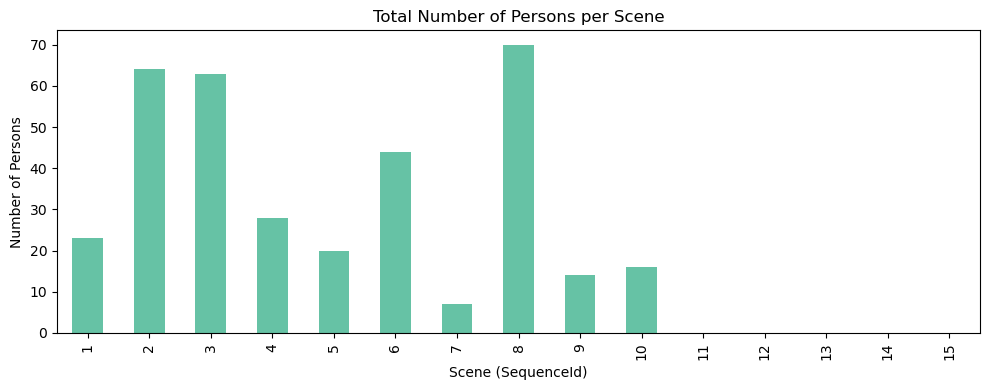

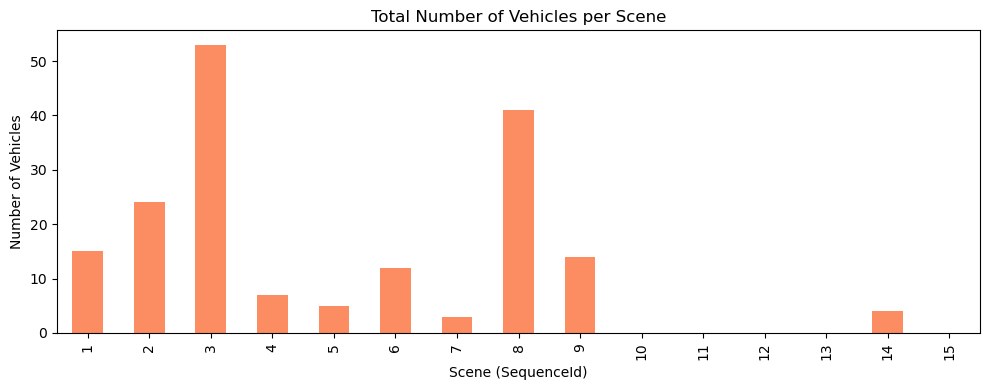

In [317]:
def plot_object_counts(object_data: pd.DataFrame, object_types: List[str]) -> None:
    """
    Plot the total number of objects per scene.

    Args:
        object_data (pd.DataFrame): Tracking data for objects
        object_types (List[str]): Types of objects to plot
    """
    object_data = object_data.copy()
    for obj_type in object_types:
        filtered_data = object_data[object_data["LabelClass"] == obj_type]
        filtered_data = filtered_data.drop_duplicates(subset=['SequenceId', 'InstanceId'])
        object_counts = filtered_data.groupby('SequenceId').size()
        object_counts = object_counts.reindex(range(1, 16), fill_value=0)
        
        # Create the bar plot
        plt.figure(figsize=(10, 4))
        colors = sns.color_palette('Set2', n_colors=len(object_types))
        object_counts.plot(kind='bar', color=colors[object_types.index(obj_type)])
        plt.title(f'Total Number of {obj_type.capitalize()}s per Scene')
        plt.xlabel('Scene (SequenceId)')
        plt.ylabel(f'Number of {obj_type.capitalize()}s')
        plt.tight_layout()
        plt.show()

plot_object_counts(object_data, ['person', 'vehicle'])

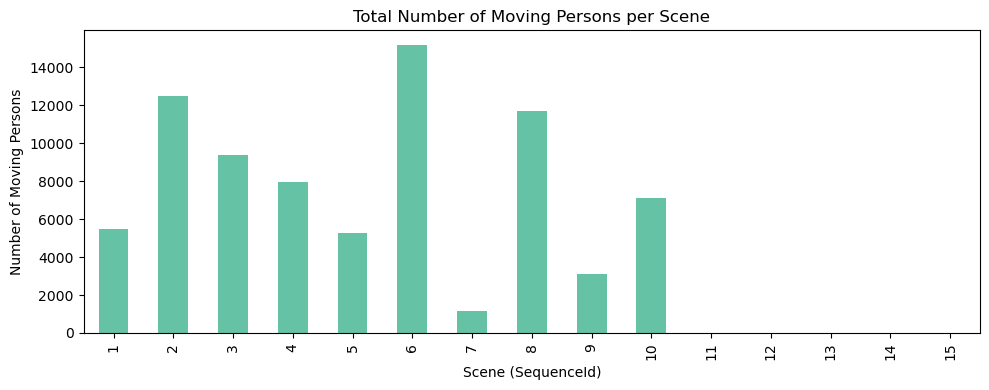

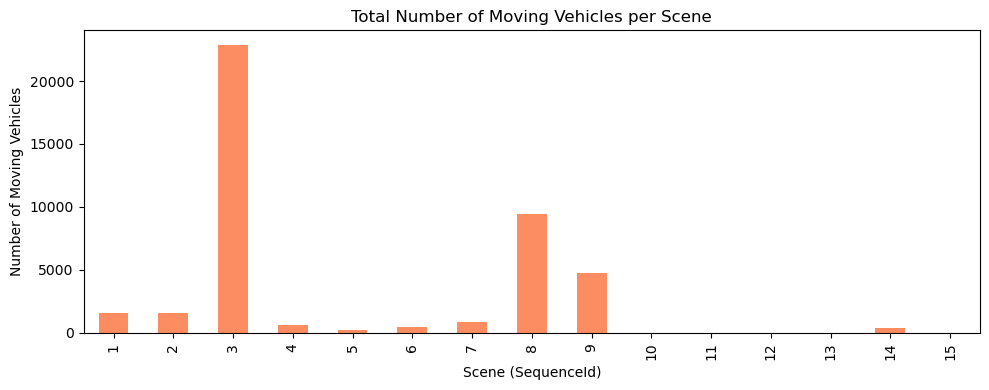

In [318]:
def plot_object_motion(object_data: pd.DataFrame, object_types: List[str]) -> None:
    """
    Plot the total number of moving objects per scene.

    Args:
        object_data (pd.DataFrame): Tracking data for objects
        object_types (List[str]): Types of objects to plot
    """
    object_data = object_data.copy()
    for obj_type in object_types:
        motion_data = object_data[object_data["LabelClass"] == obj_type]
        motion_data = (
            motion_data.groupby(["SequenceId", "InstanceId"])["DistanceFromLast_px"]
            .sum()
            .reset_index()
        )
        motion_data = motion_data.groupby("SequenceId")["DistanceFromLast_px"].sum()
        motion_data = motion_data.reindex(range(1, 16), fill_value=0)

        # Plot the bar plot
        plt.figure(figsize=(10, 4))
        colors = sns.color_palette("Set2", n_colors=len(object_types))
        motion_data.plot(kind="bar", color=colors[object_types.index(obj_type)])
        plt.title(f"Total Number of Moving {obj_type.capitalize()}s per Scene")
        plt.xlabel("Scene (SequenceId)")
        plt.ylabel(f"Number of Moving {obj_type.capitalize()}s")
        plt.tight_layout()
        plt.show()

plot_object_motion(object_data, ['person', 'vehicle'])

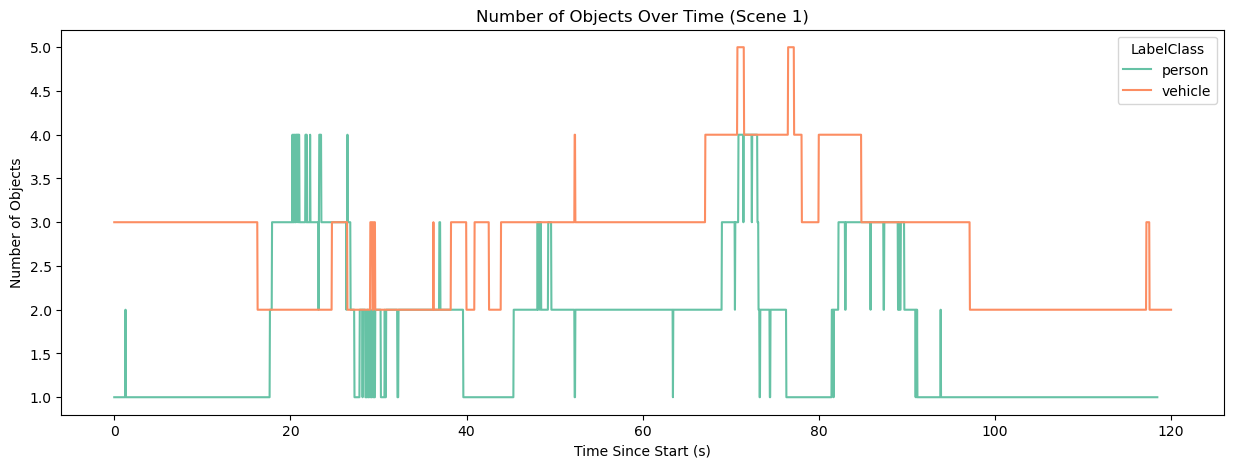

In [319]:
def plot_objects_over_time(
    data: pd.DataFrame,
    sequence_id: int,
    object_types: List[str]
):
    """
    Plot the number of objects over time for a specific scene.

    Args:
        data (pd.DataFrame): Tracking data for objects
        sequence_id (int): Sequence ID of the scene
        object_types (List[str]): Types of objects to plot
    """
    data = data.copy()
    data = data[data["SequenceId"] == sequence_id]
    data = data[data["LabelClass"].isin(object_types)]
    data["TimeSinceStart_s"] = data["TimeSinceStart_ns"] / N_NSEC_IN_SEC
    unique_data = data[["InstanceId", "LabelClass", "TimeSinceStart_s"]].copy().drop_duplicates(subset=["InstanceId", "TimeSinceStart_s"])
    unique_data = unique_data.groupby(["TimeSinceStart_s", "LabelClass"]).size().reset_index(name="Count")

    # Plot the line plot
    plt.figure(figsize=(15, 5))
    colors = sns.color_palette("Set2", n_colors=len(unique_data["LabelClass"].unique()))
    sns.lineplot(data=unique_data, x="TimeSinceStart_s", y="Count", hue="LabelClass", palette=colors)
    plt.title(f"Number of Objects Over Time (Scene {sequence_id})")
    plt.xlabel("Time Since Start (s)")
    plt.ylabel("Number of Objects")
    plt.show()

plot_objects_over_time(data=object_data, sequence_id=1, object_types=['person', 'vehicle'])

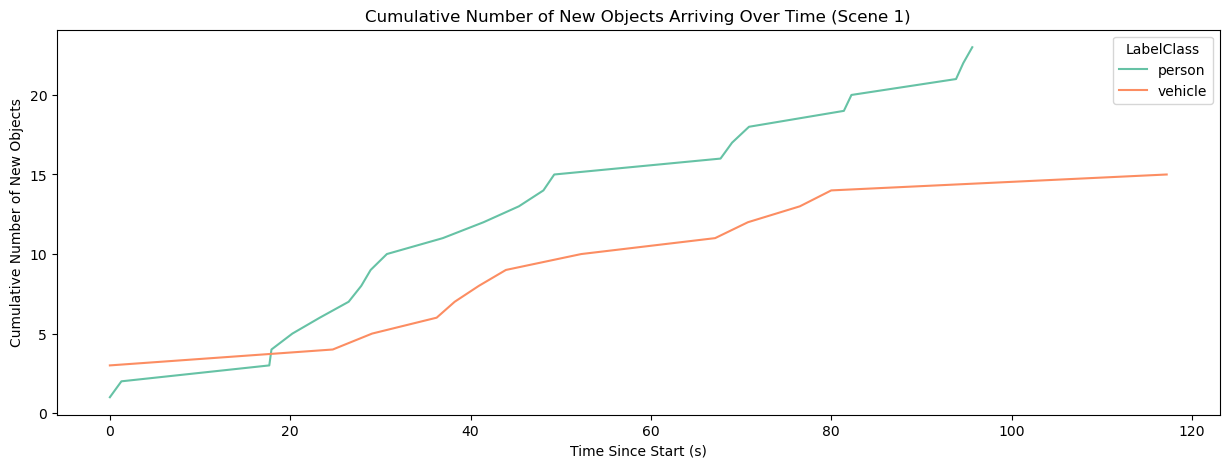

In [320]:
def plot_objects_cumulative_over_time(
    data: pd.DataFrame,
    sequence_id: int,
    object_types: List[str]
) -> None:
    """
    Plot the cumulative number of new objects arriving over time for a specific scene.

    Args:
        data (pd.DataFrame): Tracking data for objects
        sequence_id (int): Sequence ID of the scene
        object_types (List[str]): Types of objects to plot
    """
    data = data.copy()
    data = data[data["SequenceId"] == sequence_id]
    data = data[data["LabelClass"].isin(object_types)]
    data["TimeSinceStart_s"] = data["TimeSinceStart_ns"] / N_NSEC_IN_SEC
    unique_data = data[["InstanceId", "LabelClass", "TimeSinceStart_s"]].copy().drop_duplicates(subset=["InstanceId", "TimeSinceStart_s"])
    unique_data = unique_data.sort_values(by="TimeSinceStart_s")

    # Calculate cumulative count of new objects arriving in the scene
    unique_data["NewObject"] = ~unique_data.duplicated(subset=["InstanceId", "LabelClass"], keep="first")
    unique_data = unique_data[unique_data["NewObject"]]
    unique_data = unique_data.groupby(["TimeSinceStart_s", "LabelClass"]).size().reset_index(name="NewCount")
    unique_data["CumulativeNewObjects"] = unique_data.groupby("LabelClass")["NewCount"].cumsum()

    # Plot the line plot
    plt.figure(figsize=(15, 5))
    colors = sns.color_palette("Set2", n_colors=len(unique_data["LabelClass"].unique()))
    sns.lineplot(data=unique_data, x="TimeSinceStart_s", y="CumulativeNewObjects", hue="LabelClass", palette=colors)
    plt.title(f"Cumulative Number of New Objects Arriving Over Time (Scene {sequence_id})")
    plt.xlabel("Time Since Start (s)")
    plt.ylabel("Cumulative Number of New Objects")
    plt.show()

plot_objects_cumulative_over_time(data=object_data, sequence_id=1, object_types=['person', 'vehicle'])

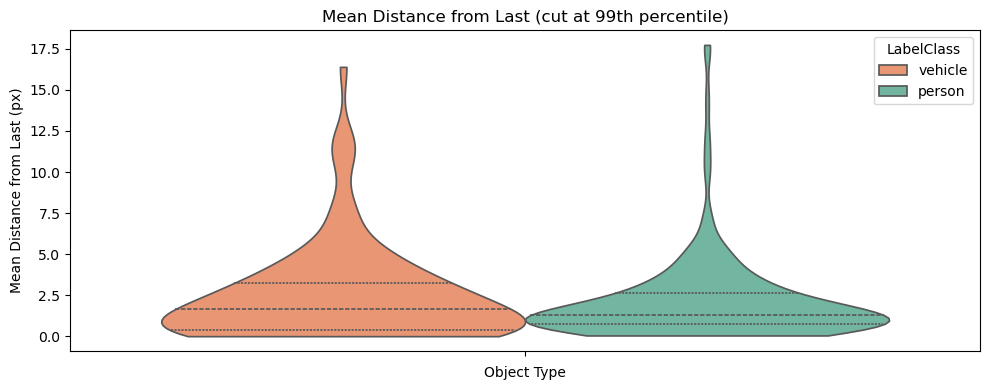

In [321]:
def plot_distance_distribution(data: pd.DataFrame) -> None:
    """
    Plot the distribution of mean distance from last for each object type.

    Args:
        data (pd.DataFrame): Tracking data for objects
        object_types (List[str]): Types of objects to plot
    """
    # Only keep the first instance of each object
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "MeanDistanceFromLast_px"]).first().reset_index()

    # Remove outliers
    distance_threshold = data["MeanDistanceFromLast_px"].quantile(0.99)
    data = data[data["MeanDistanceFromLast_px"] < distance_threshold]

    # Plot the histogram
    colors = sns.color_palette("Set2", n_colors=len(data["LabelClass"].unique()))[::-1]
    plt.figure(figsize=(10, 4))
    sns.violinplot(data=data, y="MeanDistanceFromLast_px", palette=colors, hue="LabelClass", density_norm="width", cut=0, inner="quartile")
    plt.title("Mean Distance from Last (cut at 99th percentile)")
    plt.xlabel("Object Type")
    plt.ylabel("Mean Distance from Last (px)")
    plt.tight_layout()
    plt.show()

plot_distance_distribution(object_data)

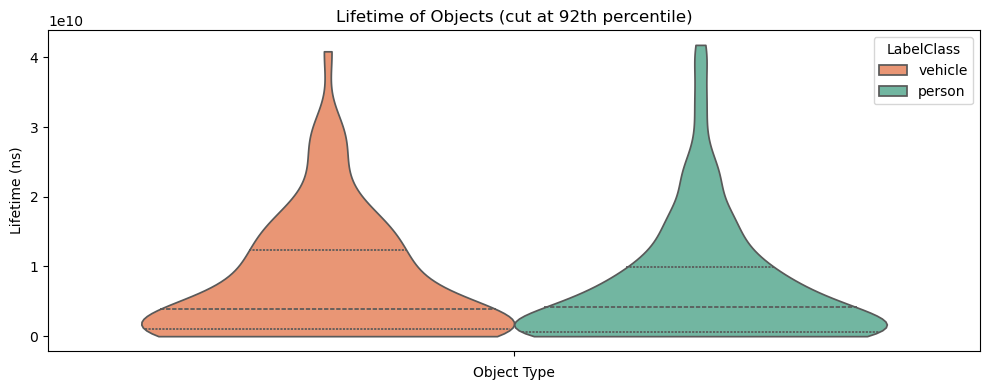

In [322]:
def plot_lifetime_distribution(data: pd.DataFrame) -> None:
    """
    Plot the distribution of lifetime for each object type.

    Args:
        data (pd.DataFrame): Tracking data for objects
    """
    # Only keep the first instance of each object
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "Lifetime_ns"]).first().reset_index()

    # Remove outliers
    lifetime_threshold = data["Lifetime_ns"].quantile(0.92)
    data = data[data["Lifetime_ns"] < lifetime_threshold]

    # Plot the histogram
    colors = sns.color_palette("Set2", n_colors=len(data["LabelClass"].unique()))[::-1]
    plt.figure(figsize=(10, 4))
    sns.violinplot(data=data, y="Lifetime_ns", hue="LabelClass", palette=colors, cut=0, inner="quartile")
    plt.title("Lifetime of Objects (cut at 92th percentile)")
    plt.xlabel("Object Type")
    plt.ylabel("Lifetime (ns)")
    plt.tight_layout()
    plt.show()

# Call the function with the appropriate data
plot_lifetime_distribution(object_data)

## Merge Data

In [323]:
def merge_data(
    fixation_data: pd.DataFrame,
    object_data: pd.DataFrame,
    time_threshold_ns: float = 0.1 * N_NSEC_IN_SEC,
) -> pd.DataFrame:
    """
    Merge gaze and object tracking data.

    Args:
        gaze_data (pd.DataFrame): Gaze data
        object_data (pd.DataFrame): Tracking data for objects
        time_threshold_s (float): Maximum time difference between gaze point and object

    Returns:
        pd.DataFrame: Merged data
    """
    merged_data = []
    for sequence_id in tqdm(
        fixation_data["SequenceId"].unique(), desc="⌛ Processing sequences..."
    ):
        # Get sequence data
        gaze_sequence_data = fixation_data[fixation_data["SequenceId"] == sequence_id]
        object_sequence_data = object_data[object_data["SequenceId"] == sequence_id]

        # Skip if no object data for the sequence
        if object_sequence_data.empty or gaze_sequence_data.empty:
            continue

        # Use KDTree for spatio-temporal-based filtering
        object_times = object_sequence_data["TimeSinceStart_ns"].values.reshape(-1, 1)
        temporal_tree = KDTree(object_times)
        gaze_times = gaze_sequence_data["TimeSinceStart_ns"].values.reshape(-1, 1)
        temporal_indices = temporal_tree.query_ball_point(gaze_times, time_threshold_ns)

        # Iterate over gaze points and query nearest objects within distance threshold
        temporal_matches = []
        for gaze_idx, obj_indices in enumerate(temporal_indices):
            if len(obj_indices) == 0:
                continue

            gaze_row = gaze_sequence_data.iloc[gaze_idx]
            candidate_objects = object_sequence_data.iloc[obj_indices]
            candidate_objects = candidate_objects.assign(
                FixationId=gaze_row["FixationId"],
                FixationX_px=gaze_row["X_px"],
                FixationY_px=gaze_row["Y_px"],
                FixationDuration_ns=gaze_row["Duration_ns"],
                FixationTimeSinceStart_ns=gaze_row["TimeSinceStart_ns"],
            )
            temporal_matches.append(candidate_objects)

        if not temporal_matches:
            continue

        temporal_matches = pd.concat(temporal_matches, ignore_index=True)

        # Calculate distances and filter based on spatial distance threshold
        x_min = (
            temporal_matches["CenterX_px"]
            - temporal_matches["Width_px"] / 2
        )
        x_max = (
            temporal_matches["CenterX_px"]
            + temporal_matches["Width_px"] / 2
        )
        y_min = (
            temporal_matches["CenterY_px"]
            - temporal_matches["Height_px"] / 2
        )
        y_max = (
            temporal_matches["CenterY_px"]
            + temporal_matches["Height_px"] / 2
        )
        within_bounds_mask = (
            (temporal_matches["FixationX_px"] >= x_min)
            & (temporal_matches["FixationX_px"] <= x_max)
            & (temporal_matches["FixationY_px"] >= y_min)
            & (temporal_matches["FixationY_px"] <= y_max)
        )
        valid_matches = temporal_matches[within_bounds_mask]

        merged_data.extend(valid_matches.to_dict(orient="records"))
    merged_data = pd.DataFrame(merged_data)

    # At this point, every fixation is linked to every object in a time window defined by time_threshold_ns
    # We need to filter the data to keep only the first fixation for each object
    merged_data = merged_data.sort_values(["SequenceId", "InstanceId", "FixationId", "FixationTimeSinceStart_ns"])
    merged_data = merged_data.groupby(["SequenceId", "InstanceId", "FixationId"], as_index=False).first()

    return merged_data


merged_data = merge_data(fixation_data=fixation_data, object_data=object_data)
display(merged_data)

⌛ Processing sequences...: 100%|██████████| 15/15 [01:08<00:00,  4.60s/it]


,SequenceId,InstanceId,FixationId,FrameId,LabelStr,LabelClass,CenterX_px,CenterY_px,Width_px,Height_px,...,AngleFromLast_deg,TimeSinceStart_ns,TimeSinceAppearance_ns,StartTime_ns,Lifetime_ns,MeanDistanceFromLast_px,FixationX_px,FixationY_px,FixationDuration_ns,FixationTimeSinceStart_ns
0,1,0,5293.0,35,car,vehicle,3345.285476,2488.441570,309.811969,248.130798,...,15.407704,1.400000e+09,1.400000e+09,0.000000e+00,1.200000e+11,0.017606,3432.2017,2495.9648,200000000.0,1.475000e+09
1,1,0,5296.0,64,car,vehicle,3345.226002,2487.568605,309.434765,248.873329,...,-156.467651,2.560000e+09,2.560000e+09,0.000000e+00,1.200000e+11,0.017606,3246.4492,2447.8940,175000000.0,2.625000e+09
2,1,0,5322.0,305,car,vehicle,3345.308639,2487.712936,309.715809,250.208899,...,-113.558114,1.220000e+10,1.220000e+10,0.000000e+00,1.200000e+11,0.017606,3248.2126,2603.7810,450000000.0,1.227500e+10
3,1,0,5332.0,412,car,vehicle,3345.342446,2487.020058,309.213724,249.174207,...,87.797402,1.648000e+10,1.648000e+10,0.000000e+00,1.200000e+11,0.017606,3272.1626,2595.4840,250000000.0,1.655000e+10
4,1,0,5357.0,682,car,vehicle,3345.477045,2487.348837,309.030122,250.036510,...,-80.537678,2.728000e+10,2.728000e+10,0.000000e+00,1.200000e+11,0.017606,3409.3650,2452.4006,150000000.0,2.735000e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,14,1,143302.0,472,car,vehicle,3629.593072,2783.166933,592.029532,457.605942,...,151.189206,1.888000e+10,1.888000e+10,0.000000e+00,1.200000e+11,0.049915,3514.8167,2991.7417,325000000.0,1.895000e+10
6878,14,1,144477.0,1519,car,vehicle,3630.525876,2783.506613,595.861326,457.118458,...,172.581350,6.076000e+10,6.076000e+10,0.000000e+00,1.200000e+11,0.049915,3686.9348,2649.4410,125000000.0,6.082500e+10
6879,14,6,43511.0,58,car,vehicle,4142.265025,2722.316424,223.051817,317.710527,...,-124.237916,2.320000e+09,0.000000e+00,2.320000e+09,1.400000e+09,0.064912,4053.6390,2821.0051,175000000.0,2.325000e+09
6880,14,6,43515.0,92,car,vehicle,4141.929466,2723.325654,227.318256,322.010255,...,-138.607648,3.680000e+09,1.360000e+09,2.320000e+09,1.400000e+09,0.064912,4216.4450,2744.1160,300000000.0,3.775000e+09


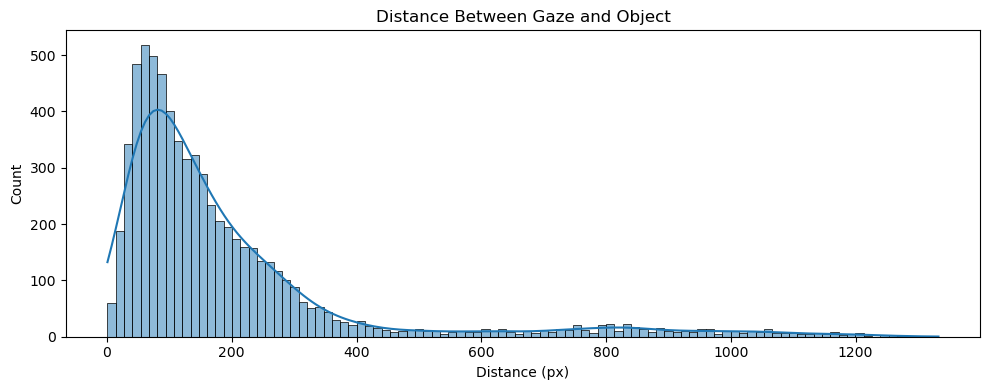

In [324]:
# plot histogram of distances between gaze and object
distances = np.sqrt(
    (merged_data["CenterX_px"] - merged_data["FixationX_px"])**2
    + (merged_data["CenterY_px"] - merged_data["FixationY_px"])**2
)
plt.figure(figsize=(10, 4))
sns.histplot(distances, bins=100, kde=True)
plt.title("Distance Between Gaze and Object")
plt.xlabel("Distance (px)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Show Video

In [294]:
def draw_objects(
    frame_id: int,
    frame: np.ndarray, 
    object_data: pd.DataFrame,
    sequence_id: int
) -> np.ndarray:
    # Filter merged data for the current sequence
    object_data = object_data.copy()
    object_data = object_data[object_data['SequenceId'] == sequence_id]
    object_data = object_data[object_data['FrameId'] == frame_id]

    # Resize the frame to the gaze frame size
    frame = cv2.resize(frame, (RAW_GAZE_FRAME_WIDTH, RAW_GAZE_FRAME_HEIGHT))

    colors = sns.color_palette("Set2", n_colors=2)
    colors = np.array(colors)[::-1, ::-1] * 255
    for _, row in object_data.iterrows():
        # Extract object information
        center_x = int(row['CenterX_px'])
        center_y = int(row['CenterY_px'])
        label = row['LabelClass']

        # Draw the object on the frame
        cv2.circle(frame, (center_x, center_y), 10, (255, 0, 0), -1)

        # Draw bounding box
        x1 = int(center_x - row['Width_px'] / 2)
        y1 = int(center_y - row['Height_px'] / 2)
        x2 = int(center_x + row['Width_px'] / 2)
        y2 = int(center_y + row['Height_px'] / 2)
        object_color = colors[object_data["LabelClass"].unique().tolist().index(label)]
        cv2.rectangle(frame, (x1, y1), (x2, y2), object_color, 8)
    # Resize the frame back to the original size
    frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

    return frame

def draw_fixations(
    frame_id: int,
    frame: np.ndarray, 
    merged_data: pd.DataFrame,
    sequence_id: int
) -> np.ndarray:
    # Filter merged data for the current sequence
    merged_data = merged_data.copy()
    merged_data = merged_data[merged_data['SequenceId'] == sequence_id]
    merged_data = merged_data[merged_data['FrameId'] == frame_id]

    # Resize the frame to the gaze frame size
    frame = cv2.resize(frame, (RAW_GAZE_FRAME_WIDTH, RAW_GAZE_FRAME_HEIGHT))

    # Draw the gaze points on the frame
    for _, row in merged_data.iterrows():
        x = int(row['FixationX_px'])
        y = int(row['FixationY_px'])
        cv2.circle(frame, (x, y), 10, (0, 255, 0), -1)

    # Resize the frame back to the original size
    frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))

    return frame

def show_video(
    sequence_id: int,
    object_data: pd.DataFrame,
    merged_data: pd.DataFrame,
) -> None:
    # Filter data for the current sequence
    merged_data = merged_data.copy()
    object_data = object_data.copy()
    merged_data = merged_data[merged_data["SequenceId"] == sequence_id]
    object_data = object_data[object_data["SequenceId"] == sequence_id]

    # Load video
    video_path = f"{SETS_PATH}/experiment1/videos/scene{sequence_id:02}.mp4"
    video = cv2.VideoCapture(video_path)

    # Play video
    paused = False
    frame_id = 0
    while True:
        if not paused:
            # Read the next frame and check if it is valid
            ret, frame = video.read()
            if not ret:
                break
            
            # Draw objects on the current frame
            frame = draw_objects(
                frame_id=frame_id,
                frame=frame, 
                object_data=object_data, 
                sequence_id=sequence_id
            )
            frame = draw_fixations(
                frame_id=frame_id,
                frame=frame, 
                merged_data=merged_data, 
                sequence_id=sequence_id
            )
            
            # Display the frame
            cv2.imshow("Video", frame)
        
        key = cv2.waitKey(1) & 0xFF

        if key == ord('q'):
            break
        elif key == ord(' '):
            paused = not paused

        if not paused:
            frame_id += 1

    # Release video and close all windows
    video.release()
    cv2.destroyAllWindows()

show_video(
    sequence_id=1,
    object_data=object_data,
    merged_data=merged_data,
)

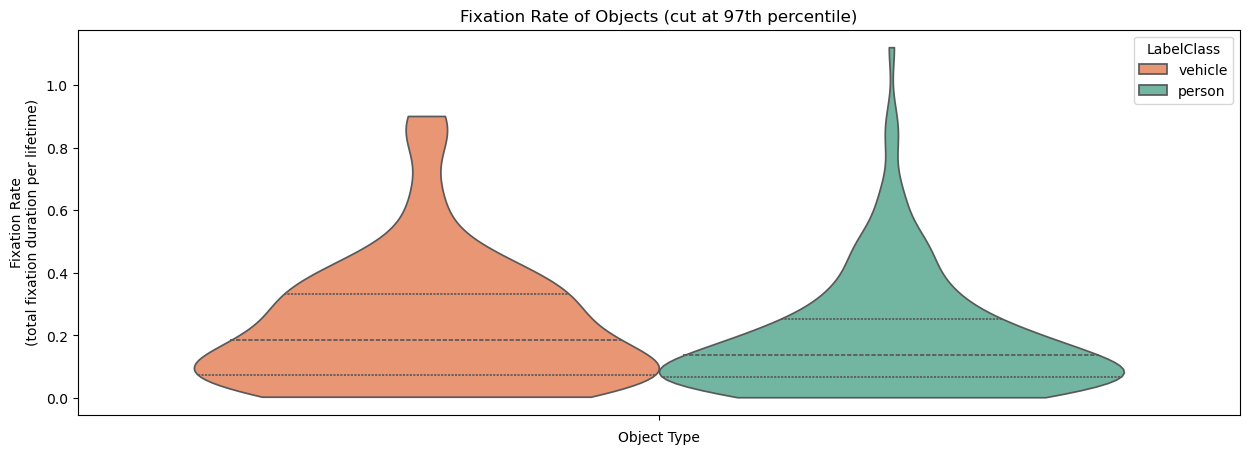

Mann-Whitney U statistic: 7219.0, p-value: 0.11121771708587201


In [325]:
def plot_object_fixation_rate_sum(data: pd.DataFrame):
    data = data.copy()

    # Get object fixation count
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        TotalDuration_ns=("FixationDuration_ns", "sum")
    ).reset_index()
    data["FixationRate"] = data["TotalDuration_ns"] / data["Lifetime_ns"]
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Plot the fixation rate
    plot1_data = data[data["FixationRate"] < data["FixationRate"].quantile(0.97)]
    plt.figure(figsize=(15, 5))
    colors = sns.color_palette("Set2", n_colors=len(plot1_data["LabelClass"].unique()))[::-1]
    sns.violinplot(data=plot1_data, hue="LabelClass", y="FixationRate", palette=colors, cut=0, inner="quartile")
    plt.title("Fixation Rate of Objects (cut at 97th percentile)")
    plt.xlabel("Object Type")
    plt.ylabel("Fixation Rate\n(total fixation duration per lifetime)")
    plt.show()

    from scipy.stats import mannwhitneyu
    class_1_data = plot1_data[plot1_data["LabelClass"] == "person"]["FixationRate"]
    class_2_data = plot1_data[plot1_data["LabelClass"] == "vehicle"]["FixationRate"]
    stat, p_value = mannwhitneyu(class_1_data, class_2_data, alternative='two-sided')
    print(f"Mann-Whitney U statistic: {stat}, p-value: {p_value}")

plot_object_fixation_rate_sum(merged_data)

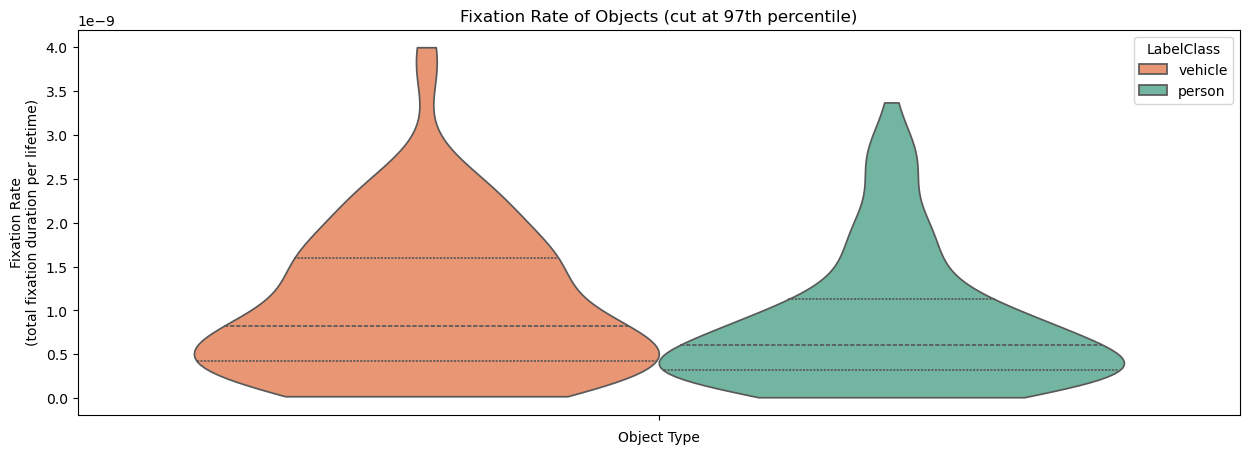

Mann-Whitney U statistic: 6771.5, p-value: 0.023639260744768683


In [326]:
def plot_object_fixation_rate_count(data: pd.DataFrame):
    data = data.copy()

    # Get object fixation count
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        FixationCount=("FixationDuration_ns", "count")
    ).reset_index()
    data["FixationRate"] = data["FixationCount"] / data["Lifetime_ns"]
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Plot the fixation rate
    plot1_data = data[data["FixationRate"] < data["FixationRate"].quantile(0.97)]
    plt.figure(figsize=(15, 5))
    colors = sns.color_palette("Set2", n_colors=len(plot1_data["LabelClass"].unique()))[::-1]
    sns.violinplot(data=plot1_data, hue="LabelClass", y="FixationRate", palette=colors, cut=0, inner="quartile")
    plt.title("Fixation Rate of Objects (cut at 97th percentile)")
    plt.xlabel("Object Type")
    plt.ylabel("Fixation Rate\n(total fixation duration per lifetime)")
    plt.show()

    from scipy.stats import mannwhitneyu
    class_1_data = plot1_data[plot1_data["LabelClass"] == "person"]["FixationRate"]
    class_2_data = plot1_data[plot1_data["LabelClass"] == "vehicle"]["FixationRate"]
    stat, p_value = mannwhitneyu(class_1_data, class_2_data, alternative='two-sided')
    print(f"Mann-Whitney U statistic: {stat}, p-value: {p_value}")

plot_object_fixation_rate_count(merged_data)

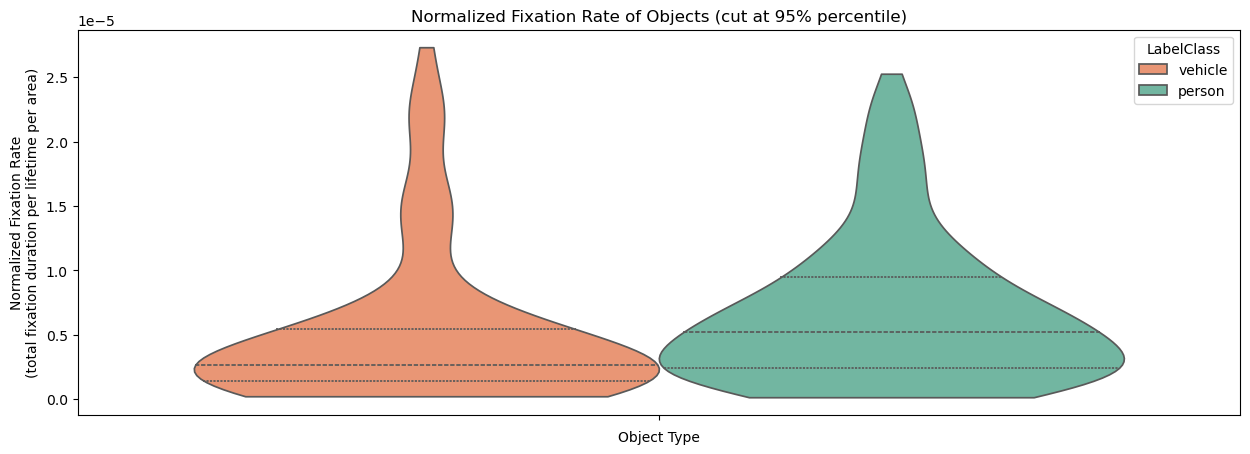

Mann-Whitney U statistic: 10476.0, p-value: 0.0004454174031943914


In [328]:
def plot_normalized_object_fixation_rate_sum(data: pd.DataFrame):
    # Get normalized object fixation count
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        TotalDuration_ns=("FixationDuration_ns", "sum"),
        MeanArea_px2=("Area_px2", "mean"),
    ).reset_index()
    data["NormalizedFixationRate"] = data["TotalDuration_ns"] / (data["Lifetime_ns"] * data["MeanArea_px2"])
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Plot the fixation rate
    plot1_data = data[data["NormalizedFixationRate"] < data["NormalizedFixationRate"].quantile(0.97)]
    plt.figure(figsize=(15, 5))
    colors = sns.color_palette("Set2", n_colors=len(plot1_data["LabelClass"].unique()))[::-1]
    sns.violinplot(data=plot1_data, hue="LabelClass", y="NormalizedFixationRate", palette=colors, cut=0, inner="quartile")
    plt.title("Normalized Fixation Rate of Objects (cut at 95% percentile)")
    plt.xlabel("Object Type")
    plt.ylabel("Normalized Fixation Rate\n(total fixation duration per lifetime per area)")
    plt.show()

    from scipy.stats import mannwhitneyu
    class_1_data = plot1_data[plot1_data["LabelClass"] == "person"]["NormalizedFixationRate"]
    class_2_data = plot1_data[plot1_data["LabelClass"] == "vehicle"]["NormalizedFixationRate"]
    stat, p_value = mannwhitneyu(class_1_data, class_2_data, alternative='two-sided')
    print(f"Mann-Whitney U statistic: {stat}, p-value: {p_value}")

plot_normalized_object_fixation_rate_sum(merged_data)

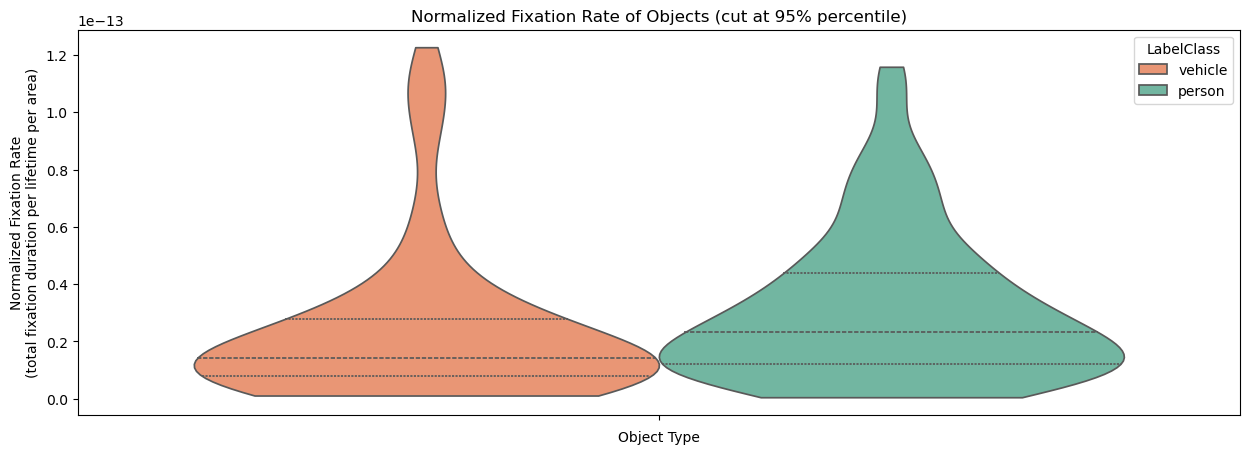

Mann-Whitney U statistic: 10385.0, p-value: 0.0007698377555765679


In [329]:
def plot_normalized_object_fixation_rate_count(data: pd.DataFrame):
    # Get normalized object fixation count
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        FixationCount=("FixationDuration_ns", "count"),
        MeanArea_px2=("Area_px2", "mean"),
    ).reset_index()
    data["NormalizedFixationRate"] = data["FixationCount"] / (data["Lifetime_ns"] * data["MeanArea_px2"])
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Plot the fixation rate
    plot1_data = data[data["NormalizedFixationRate"] < data["NormalizedFixationRate"].quantile(0.97)]
    plt.figure(figsize=(15, 5))
    colors = sns.color_palette("Set2", n_colors=len(plot1_data["LabelClass"].unique()))[::-1]
    sns.violinplot(data=plot1_data, hue="LabelClass", y="NormalizedFixationRate", palette=colors, cut=0, inner="quartile")
    plt.title("Normalized Fixation Rate of Objects (cut at 95% percentile)")
    plt.xlabel("Object Type")
    plt.ylabel("Normalized Fixation Rate\n(total fixation duration per lifetime per area)")
    plt.show()

    from scipy.stats import mannwhitneyu
    class_1_data = plot1_data[plot1_data["LabelClass"] == "person"]["NormalizedFixationRate"]
    class_2_data = plot1_data[plot1_data["LabelClass"] == "vehicle"]["NormalizedFixationRate"]
    stat, p_value = mannwhitneyu(class_1_data, class_2_data, alternative='two-sided')
    print(f"Mann-Whitney U statistic: {stat}, p-value: {p_value}")

plot_normalized_object_fixation_rate_count(merged_data)

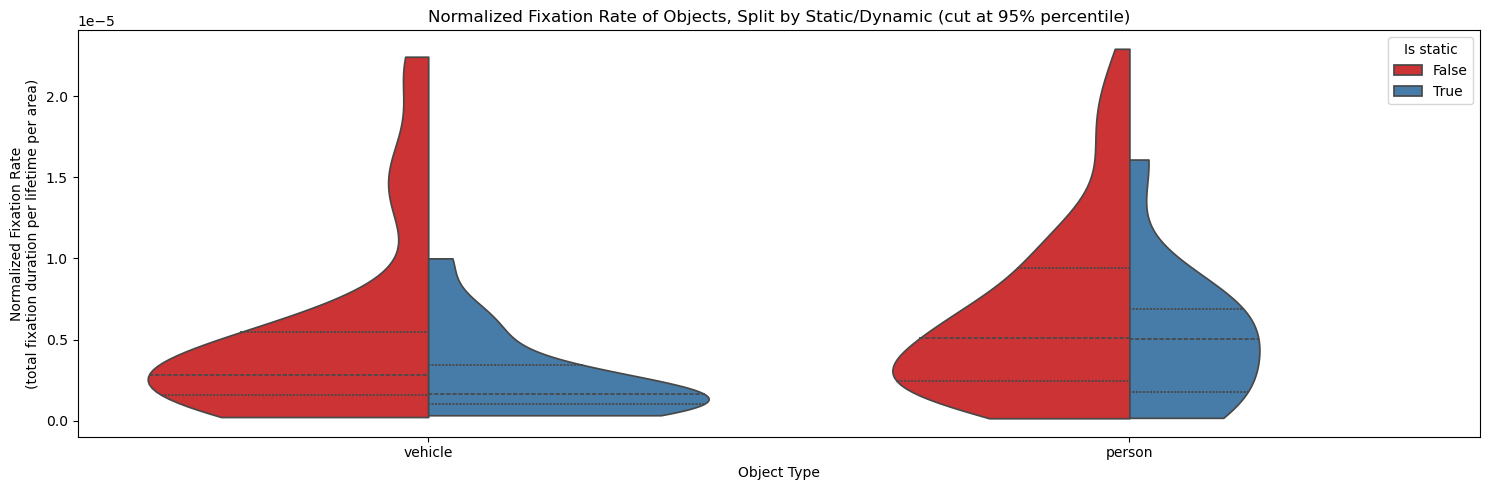

Static count:


LabelClass
person     12
vehicle    20
dtype: int64

Dynamic count:


LabelClass
person     162
vehicle     72
dtype: int64

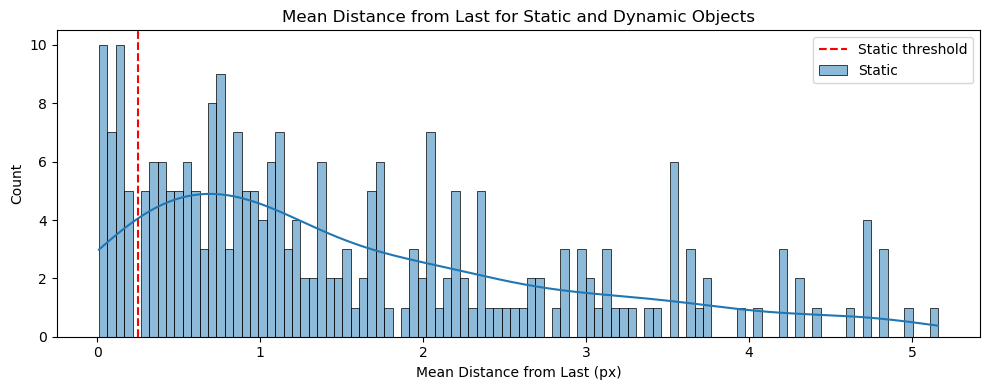

In [376]:
def plot_1203971(
    data: pd.DataFrame,
    static_threshold: float = 0.25,
):
    # Get normalized object fixation count
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        TotalDuration_ns=("FixationDuration_ns", "sum"),
        MeanArea_px2=("Area_px2", "mean"),
    ).reset_index()
    data["NormalizedFixationRate"] = data["TotalDuration_ns"] / (data["Lifetime_ns"] * data["MeanArea_px2"])
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # Remove outliers
    data = data[data["NormalizedFixationRate"] < data["NormalizedFixationRate"].quantile(0.95)]

    # Create a new column for static/dynamic classification
    data["Static"] = data["MeanDistanceFromLast_px"] < static_threshold

    # Plot the fixation rate with hue for Static and style for LabelClass
    plt.figure(figsize=(15, 5))
    sns.violinplot(
        data=data,
        x="LabelClass",
        y="NormalizedFixationRate",
        hue="Static",
        palette="Set1",
        cut=0,
        split=True,
        inner="quartile"
    )
    plt.title("Normalized Fixation Rate of Objects, Split by Static/Dynamic (cut at 95% percentile)")
    plt.xlabel("Object Type")
    plt.ylabel("Normalized Fixation Rate\n(total fixation duration per lifetime per area)")
    plt.legend(title="Is static")
    plt.tight_layout()
    plt.show()

    # Count number of static and dynamic objects for each label class
    static_data = data[data["Static"]]
    dynamic_data = data[~data["Static"]]
    static_count = static_data.groupby("LabelClass").size()
    dynamic_count = dynamic_data.groupby("LabelClass").size()
    print("Static count:")
    display(static_count)
    print("Dynamic count:")
    display(dynamic_count)

    # Show plot of meandistancefromlast for static and dynamic objects
    data = data[data["MeanDistanceFromLast_px"] < data["MeanDistanceFromLast_px"].quantile(0.95)]
    plt.figure(figsize=(10, 4))
    sns.histplot(data=data, x="MeanDistanceFromLast_px", bins=100, kde=True, label="Static")
    plt.axvline(static_threshold, color='r', linestyle='--', label='Static threshold')
    plt.title("Mean Distance from Last for Static and Dynamic Objects")
    plt.xlabel("Mean Distance from Last (px)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_1203971(merged_data)

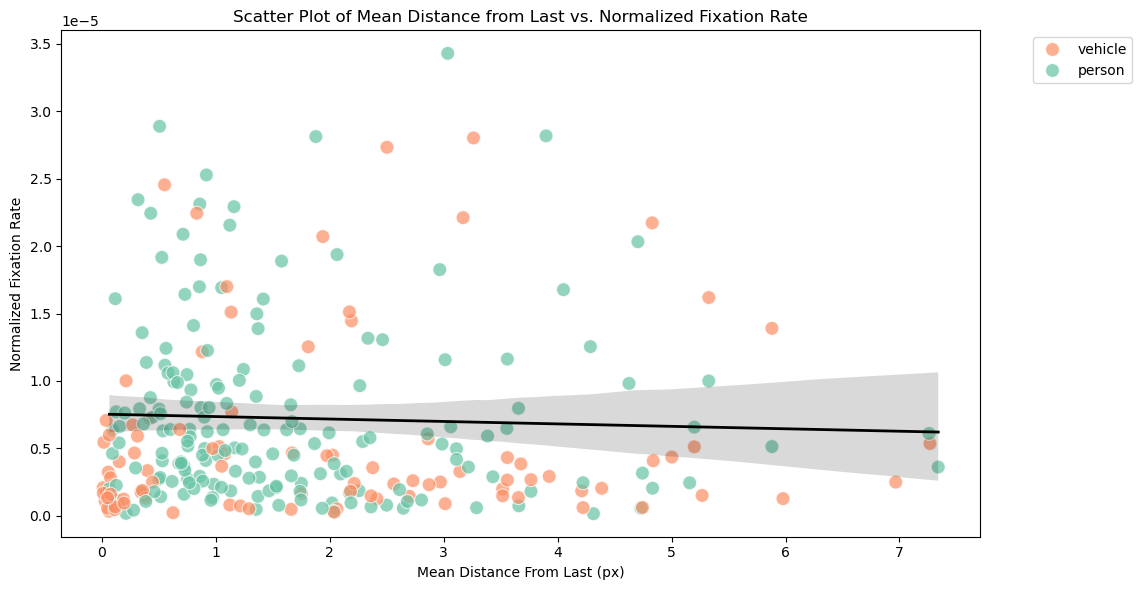

In [356]:
def plot_1203971_scatter(
    data: pd.DataFrame,
):
    # Get normalized object fixation count
    data = data.copy()
    data = data.groupby(["SequenceId", "InstanceId", "LabelClass", "Lifetime_ns", "MeanDistanceFromLast_px"]).agg(
        TotalDuration_ns=("FixationDuration_ns", "sum"),
        MeanArea_px2=("Area_px2", "mean"),
    ).reset_index()
    data["NormalizedFixationRate"] = data["TotalDuration_ns"] / (data["Lifetime_ns"] * data["MeanArea_px2"])
    data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # Remove outliers
    data = data[data["NormalizedFixationRate"] < data["NormalizedFixationRate"].quantile(0.99)]
    data = data[data["MeanDistanceFromLast_px"] < data["MeanDistanceFromLast_px"].quantile(0.99)]

    # Scatter plot with MeanDistanceFromLast_px on x-axis and NormalizedFixationRate on y-axis
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("Set2", n_colors=len(data["LabelClass"].unique()))[::-1]
    sns.scatterplot(
        data=data,
        x="MeanDistanceFromLast_px",
        y="NormalizedFixationRate",
        hue="LabelClass",  # Differentiate by object type (LabelClass)
        palette=colors,
        alpha=0.7,
        s=100  # Adjust the size of the scatter points
    )

    plt.title("Scatter Plot of Mean Distance from Last vs. Normalized Fixation Rate")
    plt.xlabel("Mean Distance From Last (px)")
    plt.ylabel("Normalized Fixation Rate")
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Call the scatter plot function
plot_1203971_scatter(merged_data)